# Author: Sevendi Eldrige Rifki Poluan

In [1]:
!nvidia-smi

Mon May 22 14:04:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.116.04   Driver Version: 525.116.04   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:65:00.0 Off |                  N/A |
|  0%   45C    P0   120W / 390W |      0MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install opencv-python

In [ ]:
!apt-get install libgl1-mesa-glx -y

# Import the required libraries

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

2023-05-22 17:07:30.163542: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Prepare the datasets

In [2]:
!ls chest_xray/train

NORMAL	PNEUMONIA


In [3]:
CLASS_NAMES = ["NORMAL", "PNEUMONIA"]

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory("chest_xray/train", label_mode="categorical", class_names=CLASS_NAMES, image_size=(224, 224), shuffle=True, seed=42, batch_size=None)
test_ds = tf.keras.preprocessing.image_dataset_from_directory("chest_xray/train", label_mode="categorical", class_names=CLASS_NAMES, image_size=(224, 224), shuffle=True, seed=42, batch_size=None)
val_ds = tf.keras.preprocessing.image_dataset_from_directory("chest_xray/train", label_mode="categorical", class_names=CLASS_NAMES, image_size=(224, 224), shuffle=True, seed=42, batch_size=None)

Found 5216 files belonging to 2 classes.
Found 5216 files belonging to 2 classes.


2023-05-22 17:07:33.899639: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22244 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6


Found 5216 files belonging to 2 classes.


# Show some sample images

2023-05-22 17:07:34.798476: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [5216]
	 [[{{node Placeholder/_0}}]]
2023-05-22 17:07:34.798691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [5216]
	 [[{{node Placeholder/_4}}]]


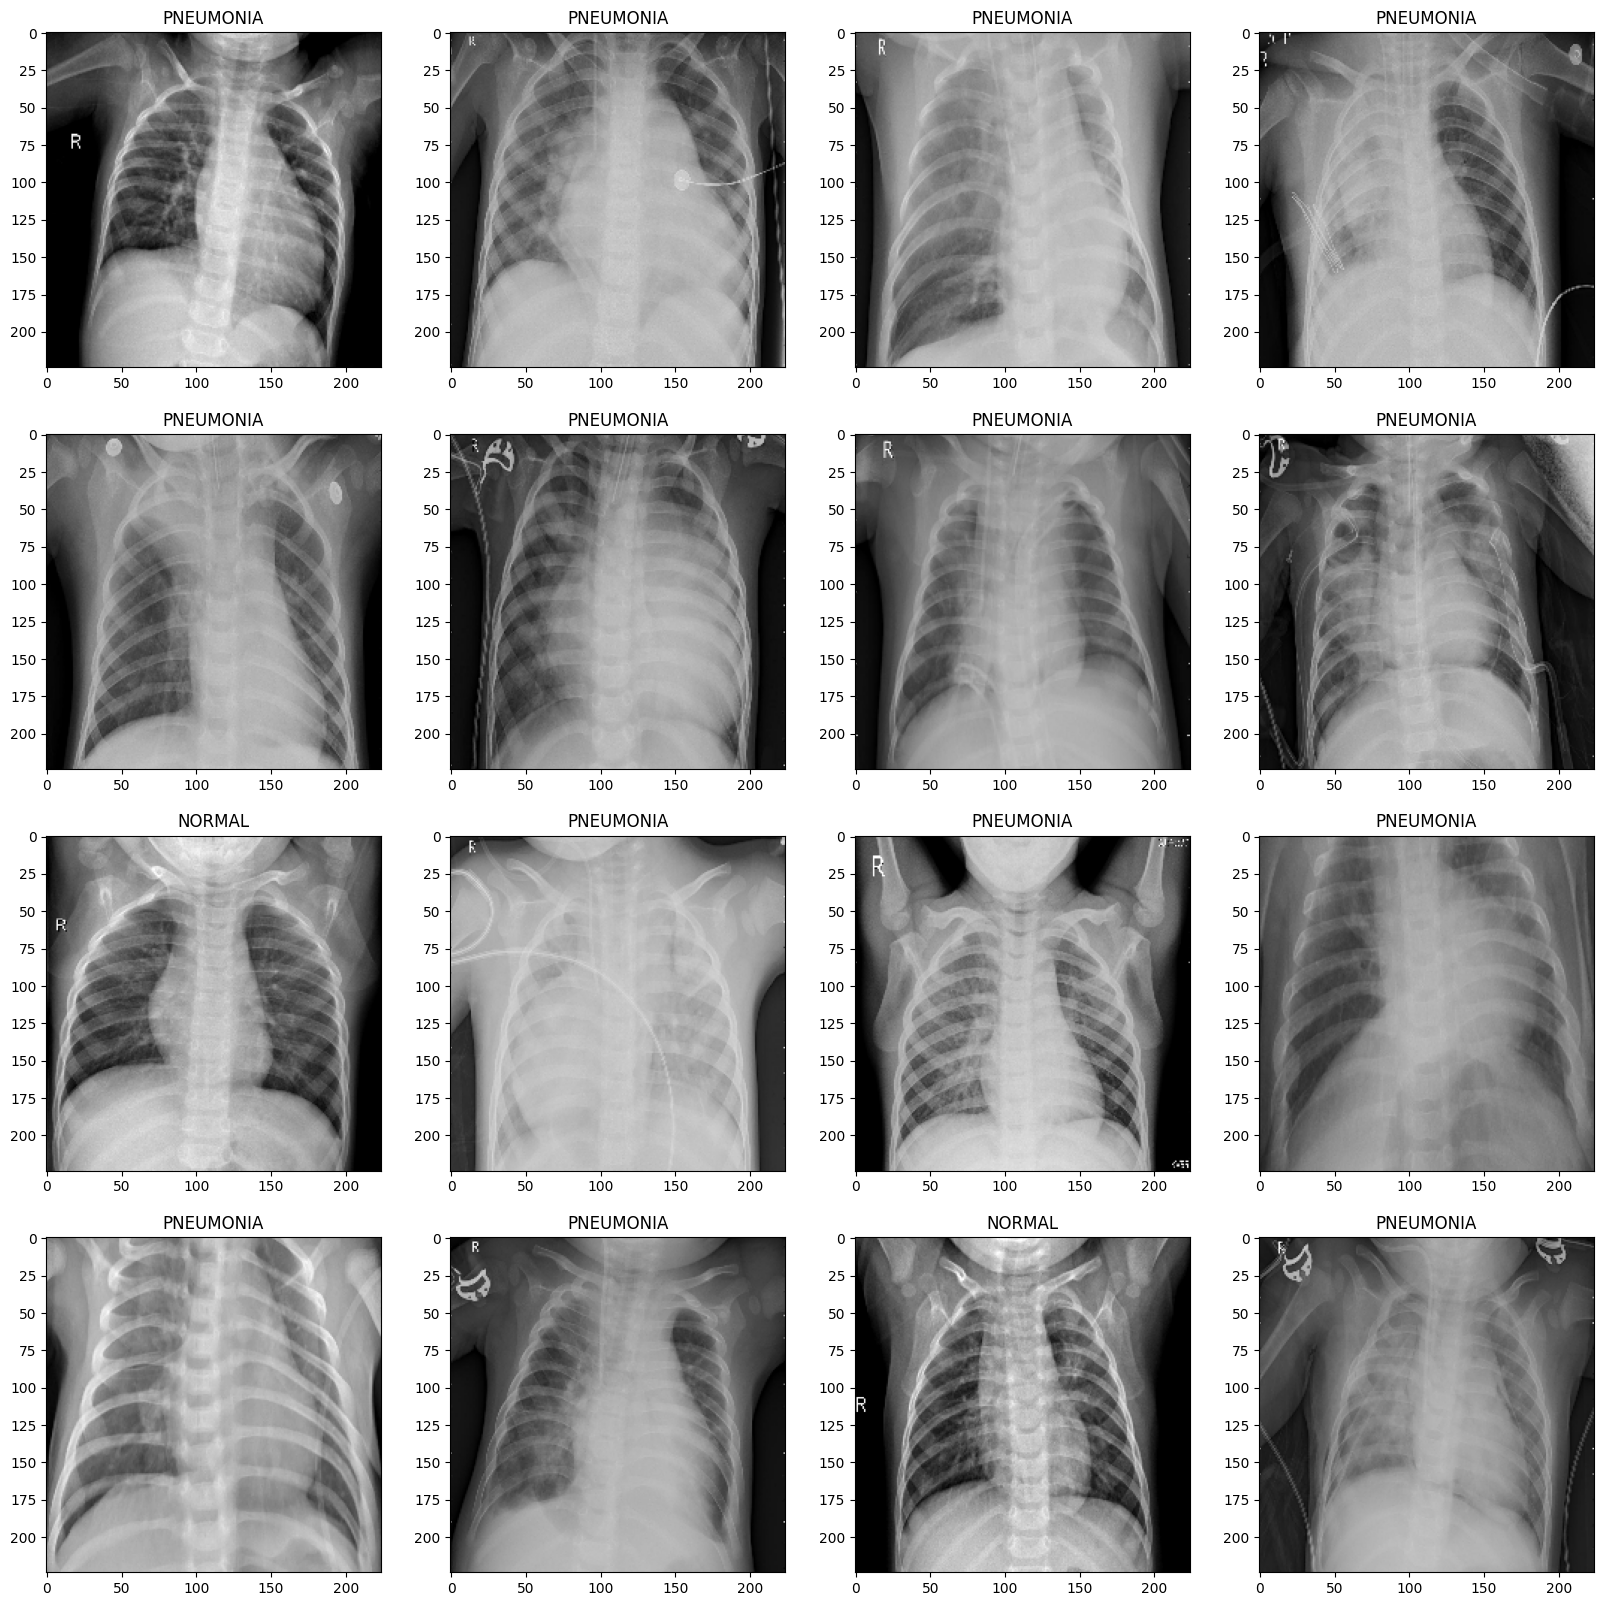

In [5]:
row, col = 4, 4
fig, axes = plt.subplots(row, col, figsize=(20, 20))

for index, x in enumerate(train_ds):
    axes[index // row, index % col].imshow(x[0].numpy().astype(int))
    axes[index // row, index % col].set_title(CLASS_NAMES[x[1].numpy().argmax()])
    
    if index == (row * col) - 1:
        break
        
plt.show()
    

# I want to use some preprocessing technique to make the images more recognizeable

In [6]:
IMG_SIZE = [256, 256]

In [7]:
class ImagePreprocess(tf.keras.layers.Layer):

    def __init__(self,  clip_limit=2, **kargs): 
        super(ImagePreprocess, self).__init__(**kargs)
        
        self.clip_limit = clip_limit 
         
        
    def call(self, inputs):  
        return tf.map_fn(self.clahe, inputs)

    def clahe(self, image):

        # Convert image to grayscale
        gray = tf.image.rgb_to_grayscale(image)

        # Apply CLAHE-like contrast adjustment using TensorFlow operations
        adjusted = tf.image.adjust_contrast(gray, contrast_factor=self.clip_limit)
 
        # Normalize the equalized image to range [0, 1]
        normalized = adjusted / 255.0

        # Convert back to RGB if the original image was RGB
        equalized = tf.tile(normalized, [1, 1, 3])

        return equalized

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

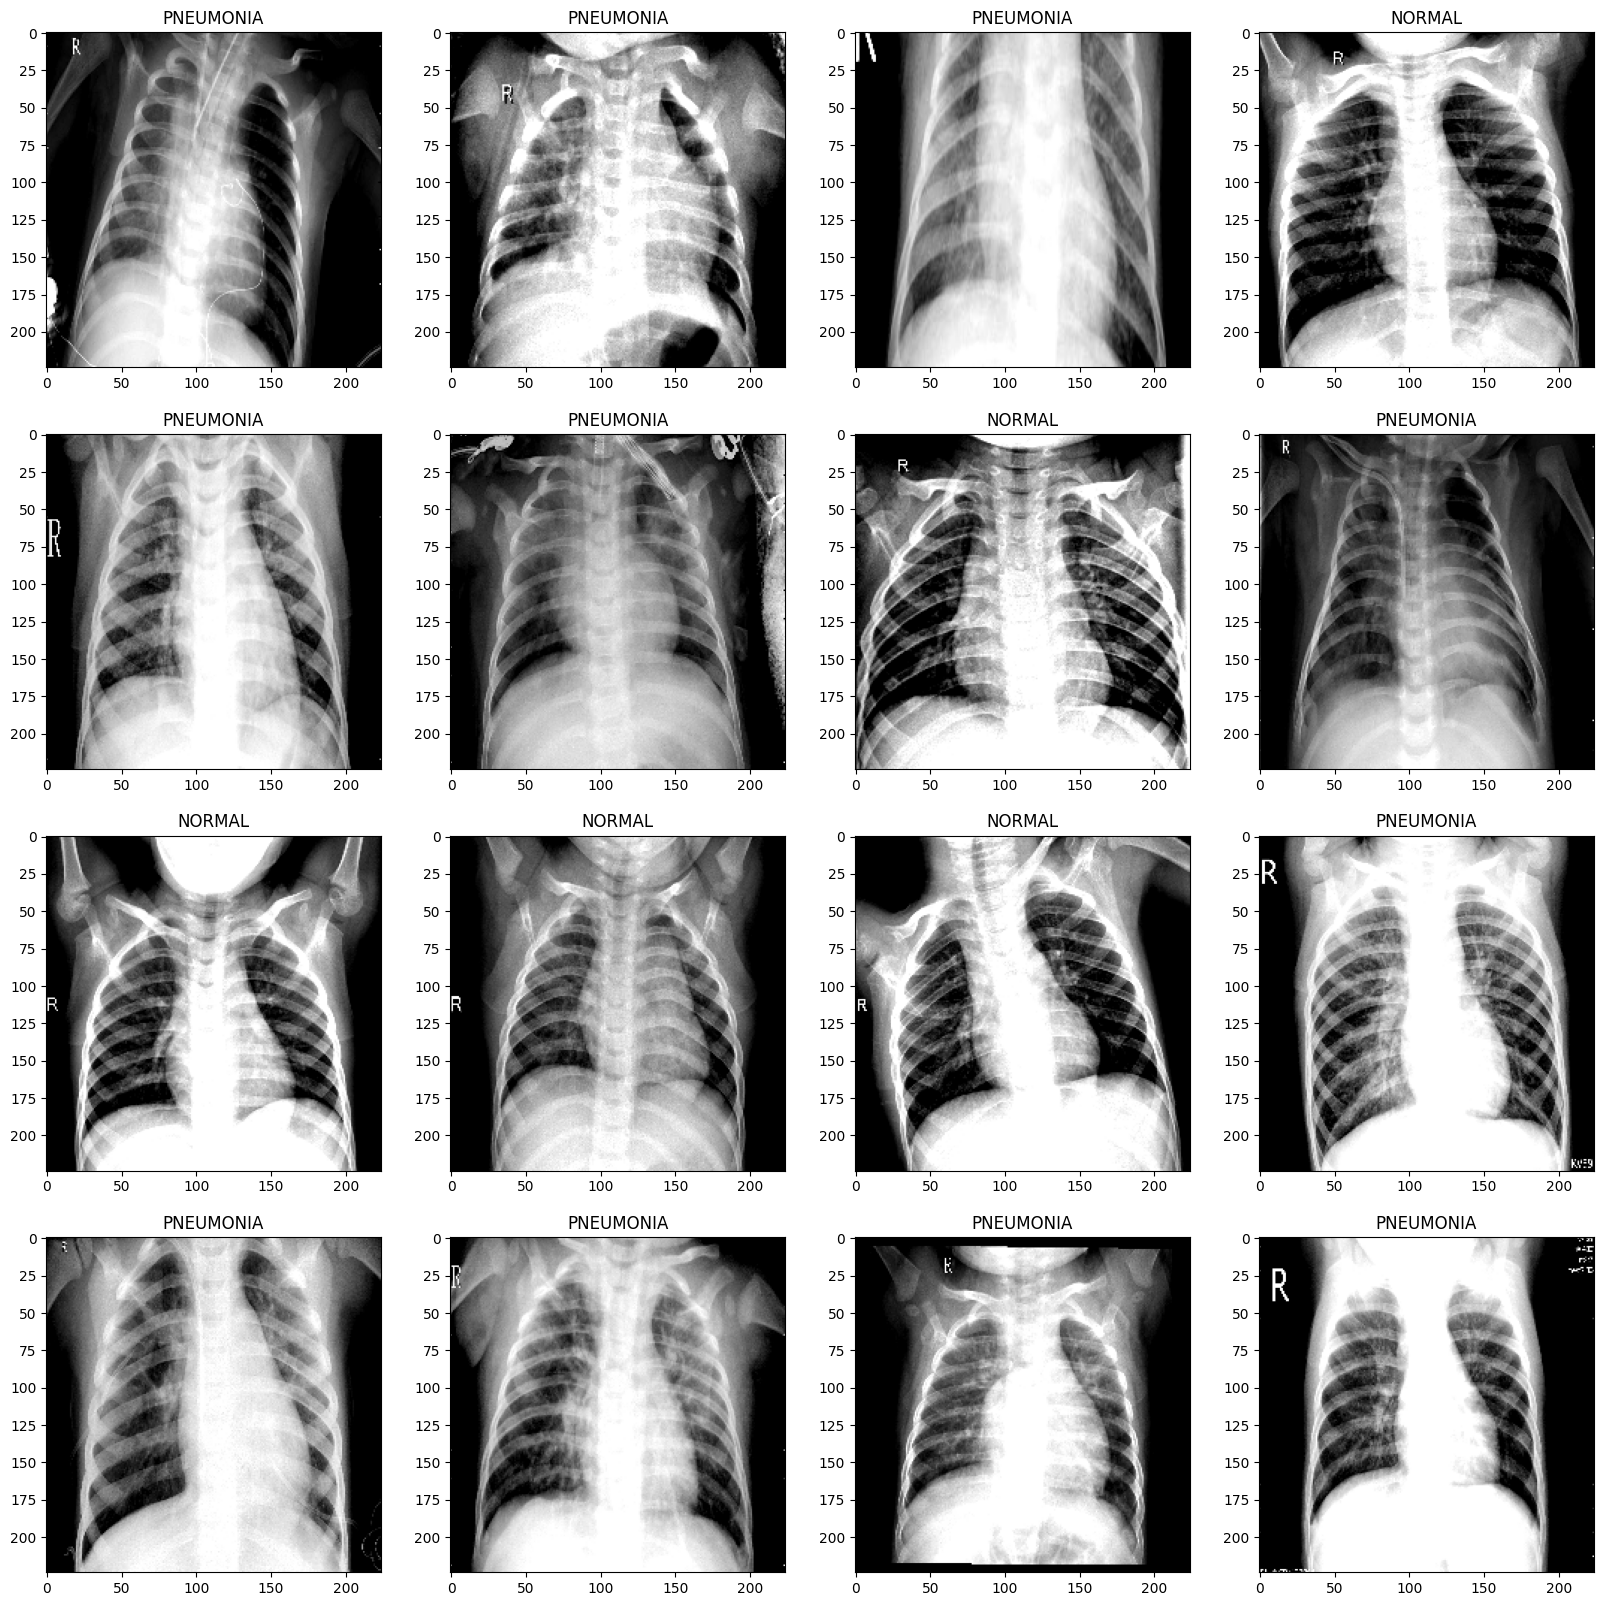

In [8]:
row, col = 4, 4
fig, axes = plt.subplots(row, col, figsize=(20, 20))
for index, x in enumerate(train_ds):
    
    # make it more readable
    after = np.squeeze(ImagePreprocess()(tf.expand_dims(x[0].numpy(), axis=0)))
    
    axes[index // row, index % col].imshow(after)
    axes[index // row, index % col].set_title(CLASS_NAMES[x[1].numpy().argmax()])
    
    if index == (row * col) - 1:
        break
        
plt.show()
    

# Prepare dataset for training

In [9]:
BATCH_SIZE = 32

def func(image, label):
    return tf.image.resize(image, IMG_SIZE), label

train = train_ds.map(func).batch(BATCH_SIZE).shuffle(1000).prefetch(tf.data.AUTOTUNE).cache()
test = test_ds.map(func).batch(BATCH_SIZE).shuffle(1000).prefetch(tf.data.AUTOTUNE)
val = val_ds.map(func).batch(BATCH_SIZE).shuffle(1000).prefetch(tf.data.AUTOTUNE)

# Build the model

In [37]:
def create_model(): 
    efficient_net = tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet", input_shape=IMG_SIZE + [3])
    efficient_net.trainable = False
    
    # inputs = tf.keras.layers.Input(shape=[None, None, 3])
    # x = ImagePreprocess()(inputs) 
    # x = tf.keras.applications.efficientnet.preprocess_input(x)
    # x = efficient_net(x)
    # x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(efficient_net.output)
    outputs = tf.keras.layers.Dense(len(CLASS_NAMES), activation="softmax")(x)
    model = tf.keras.Model(efficient_net.input, outputs)
    
    model.compile(
        loss="categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["accuracy"]
    )
    return model



In [38]:
model = create_model()

In [39]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_4 (Rescaling)        (None, 256, 256, 3)  0           ['input_4[0][0]']                
                                                                                                  
 normalization_2 (Normalization  (None, 256, 256, 3)  7          ['rescaling_4[0][0]']            
 )                                                                                                
                                                                                            

                                                                                                  
 block2a_project_conv (Conv2D)  (None, 64, 64, 24)   2304        ['block2a_se_excite[0][0]']      
                                                                                                  
 block2a_project_bn (BatchNorma  (None, 64, 64, 24)  96          ['block2a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2b_expand_conv (Conv2D)   (None, 64, 64, 144)  3456        ['block2a_project_bn[0][0]']     
                                                                                                  
 block2b_expand_bn (BatchNormal  (None, 64, 64, 144)  576        ['block2b_expand_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 block3b_expand_bn (BatchNormal  (None, 32, 32, 240)  960        ['block3b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block3b_expand_activation (Act  (None, 32, 32, 240)  0          ['block3b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3b_dwconv (DepthwiseConv2  (None, 32, 32, 240)  6000       ['block3b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3b_b

 block4b_dwconv (DepthwiseConv2  (None, 16, 16, 480)  4320       ['block4b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block4b_bn (BatchNormalization  (None, 16, 16, 480)  1920       ['block4b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4b_activation (Activation  (None, 16, 16, 480)  0          ['block4b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4b_se_squeeze (GlobalAver  (None, 480)         0           ['block4b_activation[0][0]']     
 agePoolin

                                                                                                  
 block5a_activation (Activation  (None, 16, 16, 480)  0          ['block5a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5a_se_squeeze (GlobalAver  (None, 480)         0           ['block5a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5a_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block5a_se_squeeze[0][0]']     
                                                                                                  
 block5a_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block5a_se_reshape[0][0]']     
          

                                                                                                  
 block5c_se_expand (Conv2D)     (None, 1, 1, 672)    19488       ['block5c_se_reduce[0][0]']      
                                                                                                  
 block5c_se_excite (Multiply)   (None, 16, 16, 672)  0           ['block5c_activation[0][0]',     
                                                                  'block5c_se_expand[0][0]']      
                                                                                                  
 block5c_project_conv (Conv2D)  (None, 16, 16, 112)  75264       ['block5c_se_excite[0][0]']      
                                                                                                  
 block5c_project_bn (BatchNorma  (None, 16, 16, 112)  448        ['block5c_project_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 block6b_project_bn (BatchNorma  (None, 8, 8, 192)   768         ['block6b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6b_drop (Dropout)         (None, 8, 8, 192)    0           ['block6b_project_bn[0][0]']     
                                                                                                  
 block6b_add (Add)              (None, 8, 8, 192)    0           ['block6b_drop[0][0]',           
                                                                  'block6a_project_bn[0][0]']     
                                                                                                  
 block6c_expand_conv (Conv2D)   (None, 8, 8, 1152)   221184      ['block6b_add[0][0]']            
          

                                                                                                  
 block6d_add (Add)              (None, 8, 8, 192)    0           ['block6d_drop[0][0]',           
                                                                  'block6c_add[0][0]']            
                                                                                                  
 block7a_expand_conv (Conv2D)   (None, 8, 8, 1152)   221184      ['block6d_add[0][0]']            
                                                                                                  
 block7a_expand_bn (BatchNormal  (None, 8, 8, 1152)  4608        ['block7a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7a_expand_activation (Act  (None, 8, 8, 1152)  0           ['block7a_expand_bn[0][0]']      
 ivation) 

# Callbacks

In [40]:
class ModelCheckpointCustom(tf.keras.callbacks.Callback):
    
    def __init__(self, model_path, save_best_only=False):
        super(ModelCheckpointCustom, self).__init__()
         
        self.model_path = model_path
        self.save_best_only = save_best_only
        self.best_val_loss = float('inf') 

    def on_epoch_end(self, epoch, logs=None): 
        
        current_val_loss = 0 if logs['val_loss'] is None else logs['val_loss']
         
        if self.save_best_only and current_val_loss < self.best_val_loss: 
            self.best_val_loss = current_val_loss 
            self.model.save_weights(self.model_path) 
        else: 
            self.model.save_weights(self.model_path)  

save_callbacks = ModelCheckpointCustom(model_path='saved_weights/model.weights.h5', save_best_only=True)

In [41]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5)

# Train the model

In [42]:
EPOCHS = 10
history = model.fit(train, epochs=EPOCHS, validation_data=val, validation_steps=len(val) * .2, 
                    callbacks=[early_stopping, save_callbacks])

Epoch 1/10
163/163 [==============================] - 16s 69ms/step - loss: 0.2415 - accuracy: 0.9016 - val_loss: 0.1456 - val_accuracy: 0.9451
Epoch 2/10
163/163 [==============================] - 10s 64ms/step - loss: 0.1479 - accuracy: 0.9427 - val_loss: 0.1137 - val_accuracy: 0.9583
Epoch 3/10
163/163 [==============================] - 10s 65ms/step - loss: 0.1281 - accuracy: 0.9496 - val_loss: 0.0910 - val_accuracy: 0.9716
Epoch 4/10
163/163 [==============================] - 11s 67ms/step - loss: 0.1109 - accuracy: 0.9578 - val_loss: 0.0837 - val_accuracy: 0.9697
Epoch 5/10
163/163 [==============================] - 10s 63ms/step - loss: 0.0991 - accuracy: 0.9647 - val_loss: 0.0886 - val_accuracy: 0.9659
Epoch 6/10
163/163 [==============================] - 10s 63ms/step - loss: 0.0948 - accuracy: 0.9668 - val_loss: 0.0740 - val_accuracy: 0.9725
Epoch 7/10
163/163 [==============================] - 10s 64ms/step - loss: 0.0890 - accuracy: 0.9684 - val_loss: 0.0826 - val_accuracy:

# Test the model

In [43]:
loaded_model = create_model()

In [46]:
loaded_model.load_weights("saved_weights/model.weights.h5")

In [47]:
y_pred = loaded_model.evaluate(test)

2023-05-22 17:23:43.550796: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [5216]
	 [[{{node Placeholder/_0}}]]
2023-05-22 17:23:43.551390: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [5216]
	 [[{{node Placeholder/_4}}]]


163/163 [==============================] - 11s 26ms/step - loss: 0.0643 - accuracy: 0.9795


In [48]:
print("Testing accuracy:", y_pred[1])

Testing accuracy: 0.9794861674308777


# eXplainable AI

In [357]:
class GradCAM(object):
    
    def __init__(self, model, alpha=0.8, beta=0.3):
        
        self.model = model
        self.alpha = alpha
        self.beta = beta
 
    def apply_heatmap(self, heatmap, image): 
        heatmap = cv2.resize(heatmap, image.shape[:-1]) 
        heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)   
        superimposed_img = cv2.addWeighted(np.array(image).astype(np.float32), self.alpha, np.array(heatmap).astype(np.float32), self.beta, 0)
        return np.array(superimposed_img).astype(np.uint8)
    
    def gradCAM(self, x_test=None, name='black_max_pool_2', index_class=0):
        
        with tf.GradientTape() as tape:
            
            last_conv_layer = self.model.get_layer(name) 
            grad_model = tf.keras.Model([self.model.input], [self.model.output, last_conv_layer.output])
              
            model_out, last_conv_layer = grad_model(np.expand_dims(x_test, axis=0))   
            class_out = model_out[:, index_class]  
            
            grads = tape.gradient(class_out, last_conv_layer)  
            
            pooled_grads = tf.reduce_mean(grads, axis=(0, 1))    
              
        heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=(0, 3))   
       
        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap)   
        heatmap = np.array(heatmap)
                  
        return self.apply_heatmap(heatmap, x_test)   
     

In [361]:
gradCam = GradCAM(loaded_model, alpha=0.8, beta=0.1)

2023-05-22 19:04:52.694883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [5216]
	 [[{{node Placeholder/_4}}]]
2023-05-22 19:04:52.695121: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [5216]
	 [[{{node Placeholder/_4}}]]


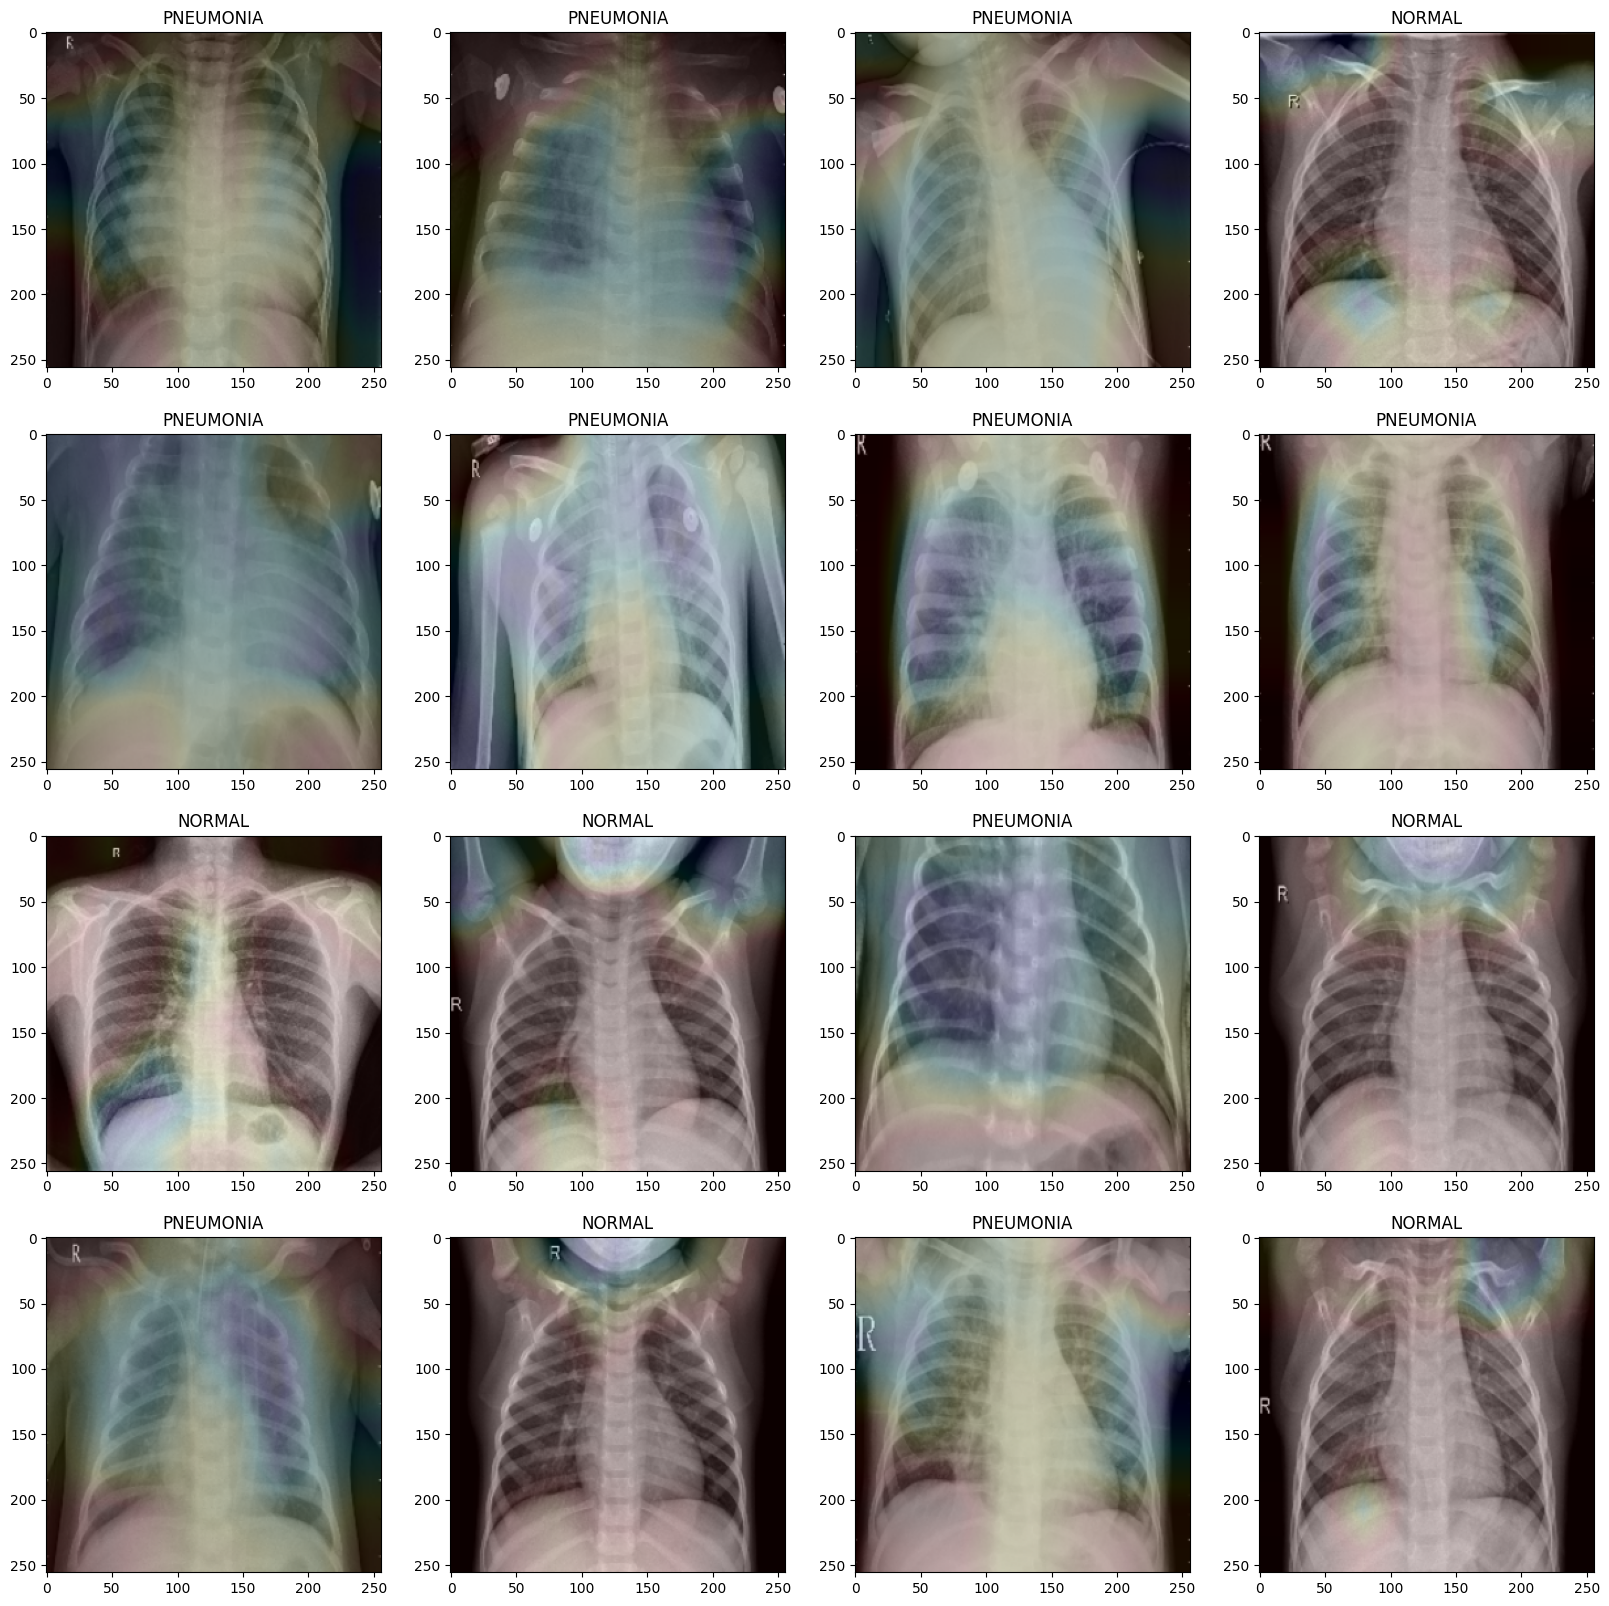

In [364]:
row, col = 4, 4
fig, axes = plt.subplots(row, col, figsize=(20, 20))
for index, x in enumerate(test_ds.take(row * col)):
    
    x_test, y_test = x 
     
    x_test = tf.image.resize(x_test, IMG_SIZE)
    y_pred = loaded_model.predict(tf.expand_dims(x_test, axis=0), verbose=0).argmax()
     
    grad_heatmap = gradCam.gradCAM(x_test, name='block7a_se_excite', index_class=y_test.numpy().argmax())
    
    axes[index // row, index % col].imshow(grad_heatmap)
    axes[index // row, index % col].set_title(CLASS_NAMES[y_pred])
    
    if index == (row * col) - 1:
        break
        
plt.show()
    